In [ ]:
!pip install transformers
import copy
import json
import os
import time
import urllib.request
import zipfile
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
from transformers import ViTModel, ViTConfig
from tqdm.notebook import tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 22.6 MB/s eta 0:00:00


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample, label = self.dataset[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample, label

In [ ]:
test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

In [ ]:
train_dataset = datasets.Flowers102(
        root='./data', split='train',
        download=True)

valid_dataset = datasets.Flowers102(
    root='./data', split='val',
    download=True,transform=test_transforms)

test_dataset = datasets.Flowers102(root='./data', split='test', download=True, transform=test_transforms)

100%|██████████| 344862509/344862509 [00:13<00:00, 24853114.98it/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 1374373.77it/s]


100%|██████████| 14989/14989 [00:00<00:00, 16013352.69it/s]


In [ ]:
train_data = CustomDataset(train_dataset, train_transforms)
train_data_no_aug = CustomDataset(train_dataset, test_transforms)
test_data = CustomDataset(test_dataset)
valid_data = CustomDataset(valid_dataset)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=64, shuffle=True)

train_loader_no_aug = torch.utils.data.DataLoader(
    train_data_no_aug, batch_size=64, shuffle=True)

valid_loader = torch.utils.data.DataLoader(
    valid_data, batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
            test_data, batch_size=64, shuffle=True)

In [ ]:
class ViT(nn.Module):

    def __init__(self, config=ViTConfig(), num_labels=102,
               model_checkpoint='google/vit-base-patch16-224-in21k'):

        super(ViT, self).__init__()

        self.vit = ViTModel.from_pretrained(model_checkpoint, add_pooling_layer=False)
        self.classifier = (
            nn.Linear(config.hidden_size, num_labels)
        )

    def forward(self, x):

        x = self.vit(x)['last_hidden_state']
        # Use the embedding of [CLS] token
        output = self.classifier(x[:, 0, :])

        return output

In [25]:
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.max_classification_acc = -np.inf

    def early_stop(self, validation_acc):
        if validation_acc > self.max_classification_acc:
            self.max_classification_acc = validation_acc
            self.counter = 0
        elif validation_acc <= (self.max_classification_acc + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

#### Does Augmentation Matter for Transformer

###### With Augmentation

In [ ]:
num_labels = 102
model = ViT()

for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTModel: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
epochs=200
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [ ]:
criteria = nn.CrossEntropyLoss().to(device)
# Observe that all parameters are being optimized
optimizer = optim.Adam(model.parameters(), lr=0.001)
#sched = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
early_stopper = EarlyStopper(patience=8, min_delta=0)

In [ ]:
def train_loop(train_loader, model, loss_fn, optimizer):
    model.train(True)
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in tqdm(train_loader, desc = 'train',leave=False):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criteria(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)

    return epoch_loss, epoch_acc

# Test function
def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    running_loss, running_corrects = 0, 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='test', leave=False):
            inputs, labels = inputs.to(device), labels.to(device) # add this line
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            loss = criteria(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(predicted == labels.data)

    test_loss = running_loss / size
    test_correct = running_corrects.double() / size

    return test_loss, test_correct

tr_loss, tr_correct = [], []
te_loss, te_correct = [], []
model.to(device)
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

for t in tqdm(range(epochs)):
    train_loss, train_correct = train_loop(train_loader, model, criteria, optimizer)
    test_loss, test_correct = test_loop(valid_loader, model, criteria)

    tr_loss.append(train_loss), tr_correct.append(train_correct)
    te_loss.append(test_loss), te_correct.append(test_correct)
    print(f"Epoch {t+1}: Train_accuracy: {(100*train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Test_accuracy: {(100*test_correct):>0.2f}%, Test_loss: {test_loss:>8f}")

    if test_correct > best_acc:
        best_acc = test_correct
        best_model_wts = copy.deepcopy(model.state_dict())
        print(f'Best Accuracy currently: {best_acc}')

    if early_stopper.early_stop(test_correct.item()):
        print("Done!")
        break

  0%|          | 0/200 [00:00<?, ?it/s]

train:   0%|          | 0/16 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1: Train_accuracy: 38.33%, Train_loss: 4.378786, Test_accuracy: 82.35%, Test_loss: 4.033735
Best Accuracy currently: 0.8235294117647058


train:   0%|          | 0/16 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 2: Train_accuracy: 90.00%, Train_loss: 3.749394, Test_accuracy: 93.04%, Test_loss: 3.451289
Best Accuracy currently: 0.9303921568627451


train:   0%|          | 0/16 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 3: Train_accuracy: 92.94%, Train_loss: 3.167523, Test_accuracy: 95.00%, Test_loss: 2.901745
Best Accuracy currently: 0.95


train:   0%|          | 0/16 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 4: Train_accuracy: 94.71%, Train_loss: 2.627822, Test_accuracy: 96.08%, Test_loss: 2.396699
Best Accuracy currently: 0.9607843137254902


train:   0%|          | 0/16 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 5: Train_accuracy: 95.10%, Train_loss: 2.136471, Test_accuracy: 95.98%, Test_loss: 1.950328


train:   0%|          | 0/16 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 6: Train_accuracy: 95.00%, Train_loss: 1.716657, Test_accuracy: 96.08%, Test_loss: 1.574200


train:   0%|          | 0/16 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 7: Train_accuracy: 95.69%, Train_loss: 1.385758, Test_accuracy: 96.27%, Test_loss: 1.276280
Best Accuracy currently: 0.9627450980392157


train:   0%|          | 0/16 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 8: Train_accuracy: 96.57%, Train_loss: 1.102321, Test_accuracy: 96.37%, Test_loss: 1.048664
Best Accuracy currently: 0.9637254901960784


train:   0%|          | 0/16 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 9: Train_accuracy: 95.88%, Train_loss: 0.894907, Test_accuracy: 96.37%, Test_loss: 0.876365


train:   0%|          | 0/16 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 10: Train_accuracy: 96.18%, Train_loss: 0.780038, Test_accuracy: 96.86%, Test_loss: 0.747310
Best Accuracy currently: 0.9686274509803922


train:   0%|          | 0/16 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 11: Train_accuracy: 96.37%, Train_loss: 0.664981, Test_accuracy: 96.76%, Test_loss: 0.650613


train:   0%|          | 0/16 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 12: Train_accuracy: 97.06%, Train_loss: 0.557985, Test_accuracy: 96.67%, Test_loss: 0.575692


train:   0%|          | 0/16 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 13: Train_accuracy: 96.27%, Train_loss: 0.519248, Test_accuracy: 96.86%, Test_loss: 0.516136


train:   0%|          | 0/16 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 14: Train_accuracy: 97.06%, Train_loss: 0.438243, Test_accuracy: 96.96%, Test_loss: 0.468387
Best Accuracy currently: 0.9696078431372549


train:   0%|          | 0/16 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 15: Train_accuracy: 96.96%, Train_loss: 0.383614, Test_accuracy: 96.86%, Test_loss: 0.429901


train:   0%|          | 0/16 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 16: Train_accuracy: 97.75%, Train_loss: 0.362929, Test_accuracy: 97.06%, Test_loss: 0.397248
Best Accuracy currently: 0.9705882352941176


train:   0%|          | 0/16 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 17: Train_accuracy: 96.76%, Train_loss: 0.359786, Test_accuracy: 97.25%, Test_loss: 0.369340
Best Accuracy currently: 0.9725490196078431


train:   0%|          | 0/16 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 18: Train_accuracy: 97.25%, Train_loss: 0.335847, Test_accuracy: 97.25%, Test_loss: 0.346738


train:   0%|          | 0/16 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 19: Train_accuracy: 97.75%, Train_loss: 0.291183, Test_accuracy: 97.35%, Test_loss: 0.327247
Best Accuracy currently: 0.9735294117647059


train:   0%|          | 0/16 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 20: Train_accuracy: 96.57%, Train_loss: 0.293088, Test_accuracy: 97.25%, Test_loss: 0.310534


train:   0%|          | 0/16 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 21: Train_accuracy: 98.43%, Train_loss: 0.250260, Test_accuracy: 97.25%, Test_loss: 0.294777


train:   0%|          | 0/16 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 22: Train_accuracy: 97.35%, Train_loss: 0.269347, Test_accuracy: 97.25%, Test_loss: 0.281300


train:   0%|          | 0/16 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 23: Train_accuracy: 97.45%, Train_loss: 0.229435, Test_accuracy: 97.25%, Test_loss: 0.269734


train:   0%|          | 0/16 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 24: Train_accuracy: 98.14%, Train_loss: 0.213517, Test_accuracy: 97.25%, Test_loss: 0.258428


train:   0%|          | 0/16 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 25: Train_accuracy: 96.57%, Train_loss: 0.244617, Test_accuracy: 97.25%, Test_loss: 0.249246


train:   0%|          | 0/16 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 26: Train_accuracy: 97.75%, Train_loss: 0.206084, Test_accuracy: 97.25%, Test_loss: 0.240815


train:   0%|          | 0/16 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 27: Train_accuracy: 98.14%, Train_loss: 0.199120, Test_accuracy: 97.25%, Test_loss: 0.232650
Done!


In [ ]:
model.load_state_dict(best_model_wts)

<All keys matched successfully>

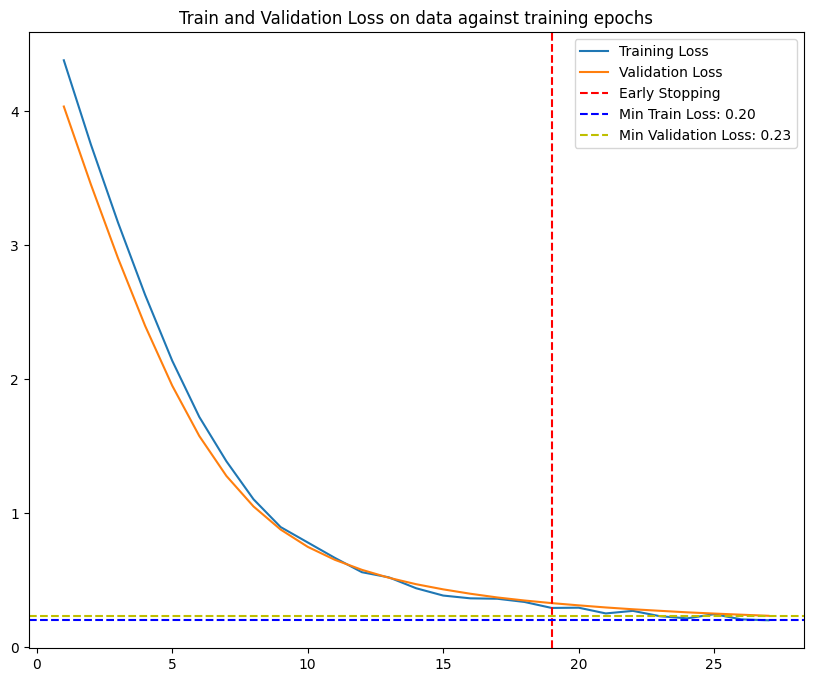

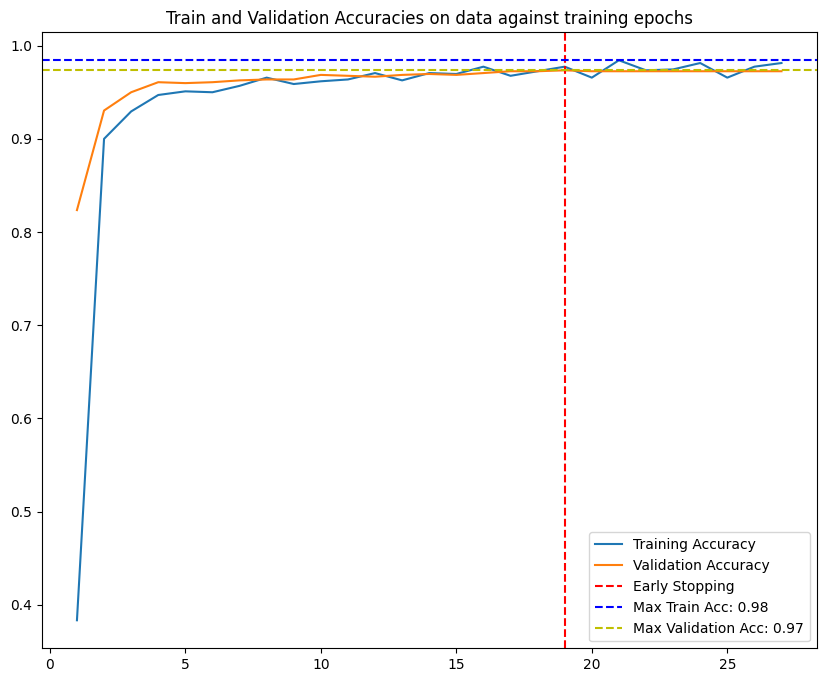

In [ ]:
early_stopping_epoch = len(tr_loss)-8
min_train_loss = min(tr_loss)
min_test_loss = min(te_loss)
max_train_accuracy = max(tr_correct).cpu()
max_test_accuracy = max(te_correct).cpu()
tr_correct1 = [i.cpu() for i in tr_correct]
te_correct1 = [i.cpu() for i in te_correct]

fig = plt.figure(figsize=(10,8))
plt.title('Train and Validation Loss on data against training epochs')
plt.plot(range(1,len(tr_loss)+1),tr_loss, label='Training Loss')
plt.plot(range(1,len(te_loss)+1),te_loss,label='Validation Loss')
plt.axvline(x=early_stopping_epoch, color='r', linestyle='--', label='Early Stopping')
plt.axhline(y=min_train_loss, color='b', linestyle='--', label=f'Min Train Loss: {min_train_loss:.2f}')
plt.axhline(y=min_test_loss, color='y', linestyle='--', label=f'Min Validation Loss: {min_test_loss:.2f}')
plt.legend()
plt.show()

fig = plt.figure(figsize=(10,8))
plt.title('Train and Validation Accuracies on data against training epochs')
plt.plot(range(1,len(tr_correct1)+1),tr_correct1, label='Training Accuracy')
plt.plot(range(1,len(te_correct1)+1),te_correct1, label='Validation Accuracy')
plt.axvline(x=early_stopping_epoch, color='r', linestyle='--', label='Early Stopping')
plt.axhline(y=max_train_accuracy, color='b', linestyle='--', label=f'Max Train Acc: {max_train_accuracy:.2f}')
plt.axhline(y=max_test_accuracy, color='y', linestyle='--', label=f'Max Validation Acc: {max_test_accuracy:.2f}')
plt.legend()
plt.show()

In [ ]:
correct = 0
total = 0
list_predicted = []
list_labels = []
with torch.no_grad():
    for data in tqdm(test_loader, leave=False):
        images, labels = data
        images, labels = images.to(device), labels.to(device) # add this line
        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        predicted, labels = predicted.cpu(), labels.cpu()
        list_predicted.extend(predicted)
        list_labels.extend(labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy on test images: ', 100*(correct/total), '%')
aug_f1 = f1_score(list_labels, list_predicted, average='weighted')

  0%|          | 0/97 [00:00<?, ?it/s]

Accuracy on test images:  96.81248983574565 %


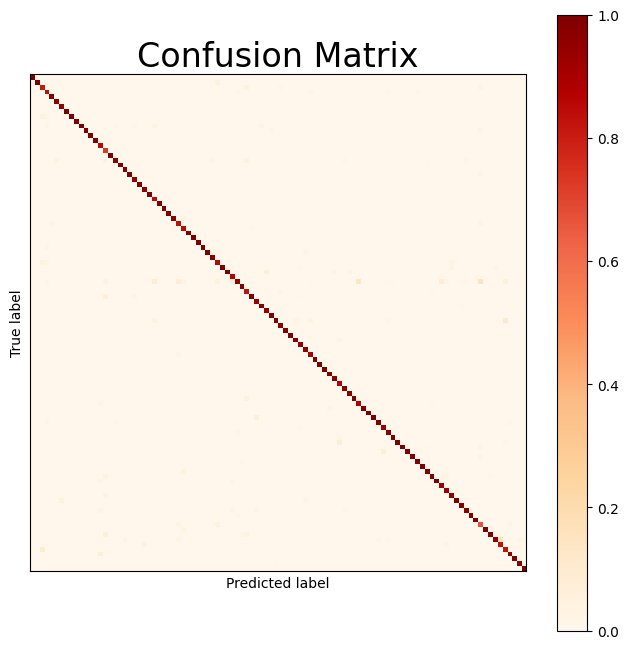

In [ ]:
c_m = confusion_matrix(list_labels, list_predicted, normalize='pred')

plt.rcParams['figure.figsize'] = (8, 8)
display_c_m = ConfusionMatrixDisplay(c_m)
display_c_m.plot(cmap='OrRd', include_values=False)

plt.title('Confusion Matrix', fontsize=24)

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
# Showing the plot
plt.show()

###### Without Augmentation

In [26]:
num_labels = 102
model = ViT()

for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTModel: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [27]:
criteria = nn.CrossEntropyLoss().to(device)
# Observe that all parameters are being optimized
optimizer = optim.Adam(model.parameters(), lr=0.001)
#sched = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
early_stopper = EarlyStopper(patience=8, min_delta=0)

In [28]:
early_stopper.counter

0

In [29]:
tr_loss, tr_correct = [], []
te_loss, te_correct = [], []
model.to(device)
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

for t in tqdm(range(epochs)):
    train_loss, train_correct = train_loop(train_loader_no_aug, model, criteria, optimizer)
    test_loss, test_correct = test_loop(valid_loader, model, criteria)

    tr_loss.append(train_loss), tr_correct.append(train_correct)
    te_loss.append(test_loss), te_correct.append(test_correct)
    print(f"Epoch {t+1}: Train_accuracy: {(100*train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Test_accuracy: {(100*test_correct):>0.2f}%, Test_loss: {test_loss:>8f}")

    if test_correct > best_acc:
        best_acc = test_correct
        best_model_wts = copy.deepcopy(model.state_dict())
        print(f'Best Accuracy currently: {best_acc}')

    if early_stopper.early_stop(test_correct.item()):
        print("Done!")
        break

  0%|          | 0/200 [00:00<?, ?it/s]

train:   0%|          | 0/16 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1: Train_accuracy: 39.31%, Train_loss: 4.381642, Test_accuracy: 84.80%, Test_loss: 4.023806
Best Accuracy currently: 0.8480392156862745


train:   0%|          | 0/16 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 2: Train_accuracy: 94.61%, Train_loss: 3.703127, Test_accuracy: 95.78%, Test_loss: 3.413833
Best Accuracy currently: 0.957843137254902


train:   0%|          | 0/16 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 3: Train_accuracy: 98.43%, Train_loss: 3.073930, Test_accuracy: 96.47%, Test_loss: 2.838800
Best Accuracy currently: 0.9647058823529412


train:   0%|          | 0/16 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 4: Train_accuracy: 98.82%, Train_loss: 2.487370, Test_accuracy: 96.76%, Test_loss: 2.312470
Best Accuracy currently: 0.9676470588235294


train:   0%|          | 0/16 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 5: Train_accuracy: 99.02%, Train_loss: 1.963340, Test_accuracy: 97.25%, Test_loss: 1.852657
Best Accuracy currently: 0.9725490196078431


train:   0%|          | 0/16 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 6: Train_accuracy: 99.22%, Train_loss: 1.518815, Test_accuracy: 97.25%, Test_loss: 1.470831


train:   0%|          | 0/16 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 7: Train_accuracy: 99.41%, Train_loss: 1.163891, Test_accuracy: 97.25%, Test_loss: 1.175134


train:   0%|          | 0/16 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 8: Train_accuracy: 99.51%, Train_loss: 0.897497, Test_accuracy: 97.45%, Test_loss: 0.953822
Best Accuracy currently: 0.9745098039215686


train:   0%|          | 0/16 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 9: Train_accuracy: 99.51%, Train_loss: 0.703051, Test_accuracy: 97.45%, Test_loss: 0.791415


train:   0%|          | 0/16 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 10: Train_accuracy: 99.61%, Train_loss: 0.562562, Test_accuracy: 97.55%, Test_loss: 0.672519
Best Accuracy currently: 0.9754901960784313


train:   0%|          | 0/16 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 11: Train_accuracy: 99.80%, Train_loss: 0.459231, Test_accuracy: 97.55%, Test_loss: 0.582939


train:   0%|          | 0/16 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 12: Train_accuracy: 99.80%, Train_loss: 0.382775, Test_accuracy: 97.55%, Test_loss: 0.515629


train:   0%|          | 0/16 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 13: Train_accuracy: 99.90%, Train_loss: 0.324500, Test_accuracy: 97.55%, Test_loss: 0.463161


train:   0%|          | 0/16 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 14: Train_accuracy: 100.00%, Train_loss: 0.279405, Test_accuracy: 97.65%, Test_loss: 0.421003
Best Accuracy currently: 0.9764705882352941


train:   0%|          | 0/16 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 15: Train_accuracy: 100.00%, Train_loss: 0.243434, Test_accuracy: 97.75%, Test_loss: 0.387029
Best Accuracy currently: 0.9774509803921568


train:   0%|          | 0/16 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 16: Train_accuracy: 100.00%, Train_loss: 0.214456, Test_accuracy: 97.75%, Test_loss: 0.359340


train:   0%|          | 0/16 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 17: Train_accuracy: 100.00%, Train_loss: 0.190520, Test_accuracy: 97.65%, Test_loss: 0.335757


train:   0%|          | 0/16 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 18: Train_accuracy: 100.00%, Train_loss: 0.170519, Test_accuracy: 97.75%, Test_loss: 0.316106


train:   0%|          | 0/16 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 19: Train_accuracy: 100.00%, Train_loss: 0.154033, Test_accuracy: 97.84%, Test_loss: 0.298964
Best Accuracy currently: 0.9784313725490196


train:   0%|          | 0/16 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 20: Train_accuracy: 100.00%, Train_loss: 0.139718, Test_accuracy: 97.84%, Test_loss: 0.284509


train:   0%|          | 0/16 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 21: Train_accuracy: 100.00%, Train_loss: 0.127751, Test_accuracy: 97.84%, Test_loss: 0.271701


train:   0%|          | 0/16 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 22: Train_accuracy: 100.00%, Train_loss: 0.117092, Test_accuracy: 97.84%, Test_loss: 0.260149


train:   0%|          | 0/16 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 23: Train_accuracy: 100.00%, Train_loss: 0.107712, Test_accuracy: 97.84%, Test_loss: 0.250393


train:   0%|          | 0/16 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 24: Train_accuracy: 100.00%, Train_loss: 0.099671, Test_accuracy: 97.84%, Test_loss: 0.241328


train:   0%|          | 0/16 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 25: Train_accuracy: 100.00%, Train_loss: 0.092549, Test_accuracy: 97.84%, Test_loss: 0.233169


train:   0%|          | 0/16 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 26: Train_accuracy: 100.00%, Train_loss: 0.086199, Test_accuracy: 97.84%, Test_loss: 0.225970


train:   0%|          | 0/16 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 27: Train_accuracy: 100.00%, Train_loss: 0.080498, Test_accuracy: 97.84%, Test_loss: 0.219354
Done!


In [30]:
model.load_state_dict(best_model_wts)

<All keys matched successfully>

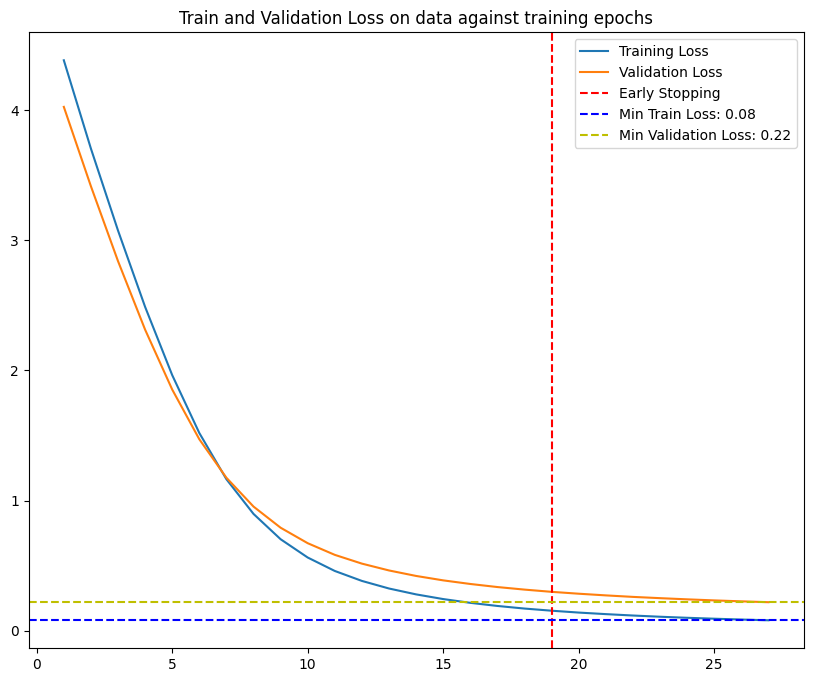

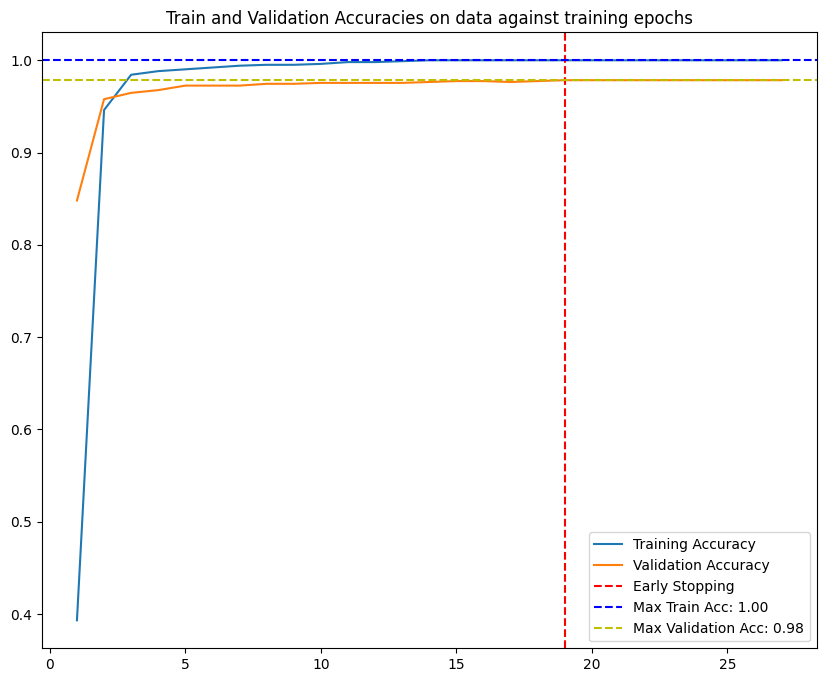

In [31]:
early_stopping_epoch = len(tr_loss)-8
min_train_loss = min(tr_loss)
min_test_loss = min(te_loss)
max_train_accuracy = max(tr_correct).cpu()
max_test_accuracy = max(te_correct).cpu()
tr_correct1 = [i.cpu() for i in tr_correct]
te_correct1 = [i.cpu() for i in te_correct]

fig = plt.figure(figsize=(10,8))
plt.title('Train and Validation Loss on data against training epochs')
plt.plot(range(1,len(tr_loss)+1),tr_loss, label='Training Loss')
plt.plot(range(1,len(te_loss)+1),te_loss,label='Validation Loss')
plt.axvline(x=early_stopping_epoch, color='r', linestyle='--', label='Early Stopping')
plt.axhline(y=min_train_loss, color='b', linestyle='--', label=f'Min Train Loss: {min_train_loss:.2f}')
plt.axhline(y=min_test_loss, color='y', linestyle='--', label=f'Min Validation Loss: {min_test_loss:.2f}')
plt.legend()
plt.show()

fig = plt.figure(figsize=(10,8))
plt.title('Train and Validation Accuracies on data against training epochs')
plt.plot(range(1,len(tr_correct1)+1),tr_correct1, label='Training Accuracy')
plt.plot(range(1,len(te_correct1)+1),te_correct1, label='Validation Accuracy')
plt.axvline(x=early_stopping_epoch, color='r', linestyle='--', label='Early Stopping')
plt.axhline(y=max_train_accuracy, color='b', linestyle='--', label=f'Max Train Acc: {max_train_accuracy:.2f}')
plt.axhline(y=max_test_accuracy, color='y', linestyle='--', label=f'Max Validation Acc: {max_test_accuracy:.2f}')
plt.legend()
plt.show()

In [32]:
correct = 0
total = 0
list_predicted = []
list_labels = []
with torch.no_grad():
    for data in tqdm(test_loader, leave=False):
        images, labels = data
        images, labels = images.to(device), labels.to(device) # add this line
        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        predicted, labels = predicted.cpu(), labels.cpu()
        list_predicted.extend(predicted)
        list_labels.extend(labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy on test images: ', 100*(correct/total), '%')
no_aug_f1 = f1_score(list_labels, list_predicted, average='weighted')

  0%|          | 0/97 [00:00<?, ?it/s]

Accuracy on test images:  97.10522036103431 %


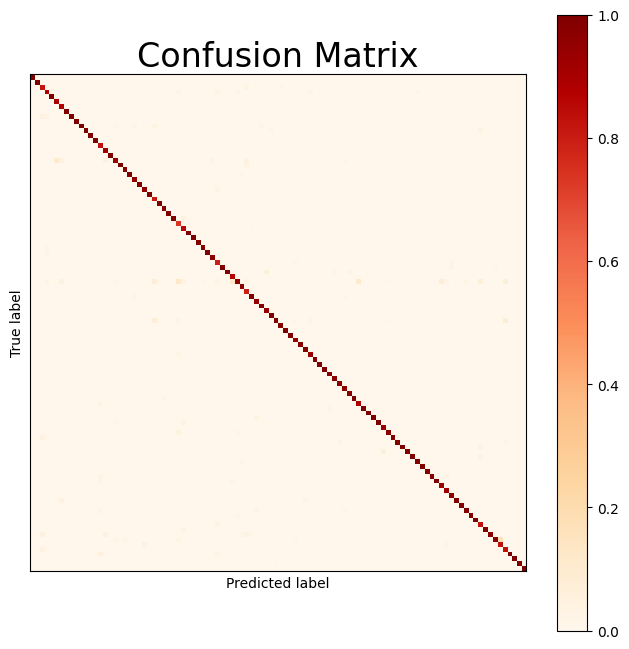

In [33]:
c_m = confusion_matrix(list_labels, list_predicted, normalize='pred')

plt.rcParams['figure.figsize'] = (8, 8)
display_c_m = ConfusionMatrixDisplay(c_m)
display_c_m.plot(cmap='OrRd', include_values=False)

plt.title('Confusion Matrix', fontsize=24)

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
# Showing the plot
plt.show()

In [34]:
print(f"""

F1 with augmentation {aug_f1}

F1 without augmentation {no_aug_f1}
""")



F1 with augmentation 0.9679681440775232

F1 without augmentation 0.9707658747162455

